In [1]:
import cv2
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
import numpy as np

from server.signal_processing import (
    sigpro_utility,
    signal_transform,
    graphing,
)

In [2]:
input_nd2 = '../../data/raw_nd2/3-SR_1_5_4h_Pre-C_1h_1mMIPTG_After2h_MCM1.nd2'
input_frames = sigpro_utility.parse_nd2_file(input_nd2)

/mnt/shared/code/damp_lab/beholder/.venv/lib/python3.8/site-packages/nd2reader/common_raw_metadata.py:99: RuntimeWarning: Reported average frame interval (194047.3 ms) doesn't match the set interval (300000.0 ms). Using the average now.
  warnings.warn(message % (avg_interval, interval), RuntimeWarning)
/mnt/shared/code/damp_lab/beholder/.venv/lib/python3.8/site-packages/nd2reader/parser.py:292: UserWarning: ND2 file contains gap frames which are represented by np.nan-filled arrays; to convert to zeros use e.g. np.nan_to_num(array)
  warnings.warn('ND2 file contains gap frames which are represented by np.nan-filled arrays; to convert to zeros use e.g. np.nan_to_num(array)')


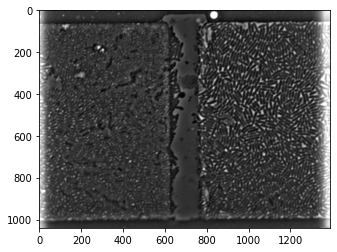

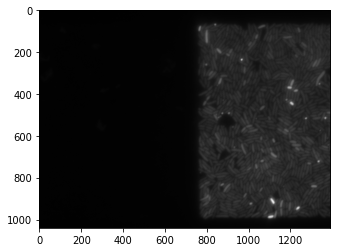

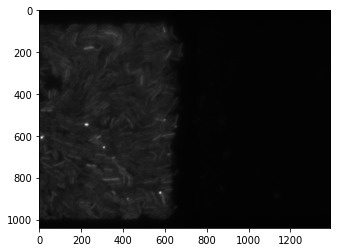

In [3]:
grey_frame = input_frames[570][0]
red_frame = input_frames[570][1]
green_frame = input_frames[570][2]

graphing.plot_notebook(grey_frame)
graphing.plot_notebook(red_frame)
graphing.plot_notebook(green_frame)

gr_hist, gr_bins = np.histogram(grey_frame, bins=15)
rd_hist, rd_bins = np.histogram(red_frame, bins=15)
gn_hist, gn_bins = np.histogram(green_frame, bins=15)
gr_center = (gr_bins[:-1] + gr_bins[1:]) / 2
gn_center = (gn_bins[:-1] + gn_bins[1:]) / 2
rd_center = (rd_bins[:-1] + rd_bins[1:]) / 2
gr_width = 0.8 * (gr_bins[1] - gr_bins[0])
gn_width = 0.8 * (gn_bins[1] - gn_bins[0])
rd_width = 0.8 * (rd_bins[1] - rd_bins[0])

<BarContainer object of 15 artists>

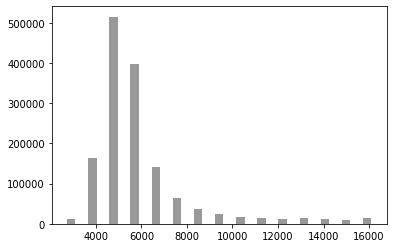

In [23]:
# Grey Frame
plt.bar(
            gr_center,
            gr_hist,
            width=gr_width/2,
            color='grey',
            alpha=0.8,
        )

<BarContainer object of 15 artists>

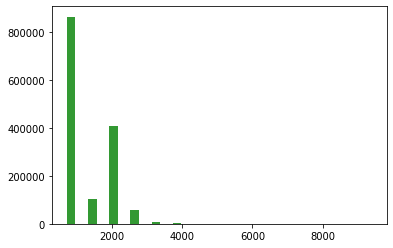

In [24]:
# Grey Frame
plt.bar(
            gn_center,
            gn_hist,
            width=gn_width/2,
            color='green',
            alpha=0.8,
        )

<BarContainer object of 15 artists>

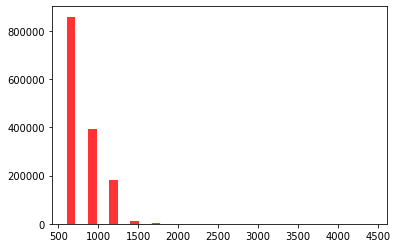

In [25]:
# Grey Frame
plt.bar(
            rd_center,
            rd_hist,
            width=rd_width/2,
            color='red',
            alpha=0.8,
        )

np.median(first_red)=699.0
np.median(final_red)=824.0
np.mean(first_red)=1223.4254683355437
np.mean(final_red)=1626.6359008896993
np.std(first_red)=727.2758009925802
np.std(final_red)=1113.3215067120723
9562
8210
557
578


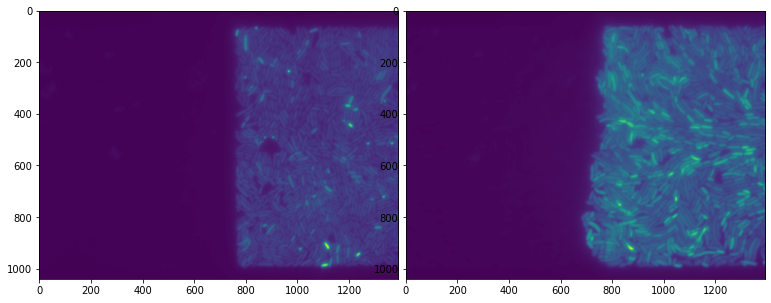

In [36]:
first_red = input_frames[570][1]
final_red = input_frames[600][1]
print(f'{np.median(first_red)=}')
print(f'{np.median(final_red)=}')
print(f'{np.mean(first_red)=}')
print(f'{np.mean(final_red)=}')
print(f'{np.std(first_red)=}')
print(f'{np.std(final_red)=}')
print(np.max(first_red))
print(np.max(final_red))
print(np.min(first_red))
print(np.min(final_red))


fig = plt.figure(figsize=(13, 6))
canvas = FigureCanvasAgg(fig)
grid = plt.GridSpec(1, 2, hspace=0.4, wspace=0.02)
# Frame Specification
ax_1 = fig.add_subplot(grid[0, 0])
ax_2 = fig.add_subplot(grid[0, 1])
ax_1.imshow(input_frames[570][1])
ax_2.imshow(input_frames[600][1])

In [244]:
def purge_blank_frames(frames):
    out_list = []
    for f_index in range(0, len(frames), 3):
        grey_frame = frames[f_index]
        red_frame = frames[f_index + 1]
        green_frame = frames[f_index + 2]
        if not any(
                map(
                    sigpro_utility.empty_frame_check,
                    [grey_frame, red_frame, green_frame]
                    )
                ):
                    out_list.append(grey_frame)
                    out_list.append(red_frame)
                    out_list.append(green_frame)
        else:
            continue
    return out_list



def fetch_and_colorize(frames):
    out_list = []
    for f in frames:
        _grey_frame, _red_frame, _green_frame = f
        _grey_frame = signal_transform.downsample_image(_grey_frame)
        _red_frame = signal_transform.downsample_image(_red_frame)
        _green_frame = signal_transform.downsample_image(_green_frame)
        _grey_frame = signal_transform.colorize_frame(_grey_frame, 'grey')
        _red_frame = signal_transform.colorize_frame(_red_frame, 'red')
        _green_frame = signal_transform.colorize_frame(_green_frame, 'green')
        _green_frame = signal_transform.apply_brightness_contrast(_green_frame)
        _red_frame = signal_transform.apply_brightness_contrast(_red_frame)
        # Below is Aesthetic, but might be wrong.
        _red_frame = cv2.addWeighted(_red_frame, 3, _red_frame, 0, 0)
        _green_frame = cv2.addWeighted(_green_frame, 1, _green_frame, 0, 0)
        out_frame = signal_transform.combine_frame(
            _grey_frame,
            _red_frame,
            beta=0.1,
        )
        out_frame = signal_transform.combine_frame(
            out_frame,
            _green_frame,
            beta=0.1,
        )
        out_frame = cv2.addWeighted(out_frame, 3, out_frame, 0, 10)
        out_list.append(out_frame)
    return out_list

def fetch_and_histogram(frames):
    out_list = []
    for f in frames:
        _, _red_frame, _green_frame = f
        freq=500000
        r_hist, r_bins = np.histogram(_red_frame, bins=10)
        r_hist[np.where(r_hist >= freq)] = 0
        r_width = 0.8 * (r_bins[1] - r_bins[0])
        r_center = (r_bins[:-1] + r_bins[1:]) / 2
        # ---
        g_hist, g_bins = np.histogram(_green_frame, bins=10)
        g_hist[np.where(g_hist >= freq)] = 0
        g_width = 0.8 * (g_bins[1] - g_bins[0])
        g_center = (g_bins[:-1] + g_bins[1:]) / 2
        out_list.append([
            [r_hist, r_bins, r_width, r_center],
            [g_hist, g_bins, g_width, g_center]
        ]
        )
    return out_list

def fetch_and_compare(frames):
    red_list = [[], [], []]
    green_list = [[], [], []]
    green_cov_l = []
    red_cov_l = []
    for f in frames:
        _, _red_frame, _green_frame = f
        green_mean = np.mean(_green_frame)
        green_cov = np.std(_green_frame)/np.mean(_green_frame)
        green_cov_l.append(green_cov)
        green_standard_error = np.std(_green_frame)/(np.sqrt(_green_frame.shape[0] * _green_frame.shape[0]))
        red_standard_error = np.std(_red_frame)/(np.sqrt(_red_frame.shape[0] * _red_frame.shape[0]))
        print(f'{green_standard_error=}')
        print(f'{red_standard_error=}')
        green_neg = green_mean - green_standard_error if green_mean - green_standard_error > 0 else 0
        green_pos = green_mean + green_standard_error
        # ---
        red_mean = np.mean(_red_frame)
        red_cov = np.std(_red_frame)/np.mean(_red_frame)
        red_cov_l.append(red_cov)
        red_neg = red_mean - red_standard_error if red_mean - red_standard_error > 0 else 0
        red_pos = red_mean + red_standard_error
        red_list[0].append(red_mean)
        red_list[1].append(red_neg)
        red_list[2].append(red_pos)
        green_list[0].append(green_mean)
        green_list[1].append(green_neg)
        green_list[2].append(green_pos)
    print(f'{green_cov_l=}')
    print(f'{red_cov_l=}')
    return [red_list, green_list]



def generate_frame_and_hist_subplot(
        frames,
        time_indicies,
        title,
        time_series_titles,
):
    fig = plt.figure(figsize=(13, 6))
    grid = plt.GridSpec(3, 5, hspace=0.4, wspace=0.02)
    plt.title(f'{title}', fontsize=16, y=1.10)
    # Frame Specification
    frame_1 = fig.add_subplot(grid[0, 0])
    frame_2 = fig.add_subplot(grid[0, 1])
    frame_3 = fig.add_subplot(grid[0, 2])
    frame_4 = fig.add_subplot(grid[0, 3])
    frame_5 = fig.add_subplot(grid[0, 4])
    ax_frame_list = [frame_1, frame_2, frame_3, frame_4, frame_5]
    col_frame_list = fetch_and_colorize(frames)
    f_iter = zip(ax_frame_list, col_frame_list, time_series_titles)
    for axis, frame, title in f_iter:
        axis.imshow(frame, interpolation='nearest')
        axis.set_title(title)
        plt.axis('off')
        axis.set_xticklabels([])
        axis.set_yticklabels([])
        axis.set_aspect('equal')
    # Histogram Specification
    hist_1 = fig.add_subplot(grid[1, 0])
    hist_2 = fig.add_subplot(grid[1, 1])
    hist_3 = fig.add_subplot(grid[1, 2])
    hist_4 = fig.add_subplot(grid[1, 3])
    hist_5 = fig.add_subplot(grid[1, 4])
    ts_1 = fig.add_subplot(grid[2, :])
    ax_hist_list = [hist_1, hist_2, hist_3, hist_4, hist_5]
    # time_series_titles = ['1', '2', '3', '4', '5']
    hist_list = fetch_and_histogram(frames)
    h_iter = zip(ax_hist_list, hist_list, time_series_titles)
    toggle = False
    for axis, hist, title in h_iter:
        red_hist_stats = hist[0]
        green_hist_stats = hist[1]
        r_hist, r_bins, r_width, r_center = red_hist_stats
        g_hist, g_bins, g_width, g_center = green_hist_stats
        g_width = 600
        # axis.set_ylim(0, 500000)
        r1 = np.arange(len(g_hist))
        r2 = [x + g_width for x in r1]
        # print(g_center)
        r_center = [pos + (g_width * 2) for pos in r_center]
        axis.set_xlim(0, 12)
        axis.set_ylim(0, 700000)
        axis.bar(
                    range(len(r_bins)-1),
                    r_hist,
                    width=1,
                    color='red',
                    alpha=1,
        )
        axis.bar(
            range(len(g_bins)-1),
            g_hist,
            width=1,
            alpha=1,
            color='green',
        )
        # tick_list = ['0', '5', '10'] if toggle else ['', '5', '10']
        # axis.set_xticklabels(tick_list)
        toggle=True
        # axis.set_xticklabels([])
        # axis.set_yticklabels([])
        axis.set_title(title)
    for ax in fig.get_axes():
        ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    hist_1.tick_params(bottom=True, labelbottom=True, left=True, labelleft=True)
    hist_1.set_ylabel('Frequency')
    hist_3.set_xlabel('Intensity, (a.u. x10^4)')
    hist_2.tick_params(bottom=True, labelbottom=True, left=False, labelleft=False)
    hist_3.tick_params(bottom=True, labelbottom=True, left=False, labelleft=False)
    hist_4.tick_params(bottom=True, labelbottom=True, left=False, labelleft=False)
    hist_5.tick_params(bottom=True, labelbottom=True, left=False, labelleft=False)
    hist_1.set_yticklabels([
        '0',
        '1/4',
        '1/2',
        '3/4',
        '1',
        ]
    )
    red_list, green_list = fetch_and_compare(frames)
    t_iter = red_list[0], green_list[0]
    ts_1.set_prop_cycle(color=['red', 'green'])
    red_neg, red_pos = red_list[1], red_list[2]
    green_neg, green_pos = green_list[1], green_list[2]
    ts_1.plot(time_indicies, t_iter[0])
    ts_1.plot(time_indicies, t_iter[1])
    ts_1.fill_between(
        time_indicies,
        green_neg,
        green_pos,
        alpha=.2,
        color='lime',
    )
    ts_1.fill_between(
            time_indicies,
            red_neg,
            red_pos,
            alpha=.8,
            color='pink',
        )
    ts_1.grid(True)
    ts_1.tick_params(bottom=True, labelbottom=True, left=True, labelleft=True)
    ts_1.set_ylabel('Intensity, (a.u. x10^4)')
    ts_1.set_xlabel('Time (h)')
    ts_1.set_xlim(570, 600)
    ts_1.set_yticklabels([
        '1.25',
        '1.50',
        '1.75',
        '2.0',
        '2.25'
        ]
    )
    ts_1.set_xticklabels([
        '0',
        '1.625',
        '3.25',
        '4.875',
        '9.75',
        '11.375',
        '13',
    ])
    # hist_3.set_title('Histogram Distribution', y=-0.1)
    plt.savefig('test.jpg', dpi=300)
    plt.show()

<ipython-input-244-ac98174f83ff>:185: UserWarning: FixedFormatter should only be used together with FixedLocator
  hist_1.set_yticklabels([
<ipython-input-244-ac98174f83ff>:219: UserWarning: FixedFormatter should only be used together with FixedLocator
  ts_1.set_yticklabels([
<ipython-input-244-ac98174f83ff>:227: UserWarning: FixedFormatter should only be used together with FixedLocator
  ts_1.set_xticklabels([


green_standard_error=0.22384549900675602
red_standard_error=0.6993036548005579
green_standard_error=0.5279506491438656
red_standard_error=0.7722200546870587
green_standard_error=2.0116350159759016
red_standard_error=0.8339086826564319
green_standard_error=4.464905902817094
red_standard_error=0.978700043652348
green_standard_error=5.559402806087642
red_standard_error=1.070501448761608
green_cov_l=[0.30184048095670685, 0.514041651567288, 0.8403962427882765, 0.9641625526477392, 0.967592441548555]
red_cov_l=[0.5944586080769029, 0.61590179904273, 0.6287448323899985, 0.6696160538299308, 0.6844319039701101]


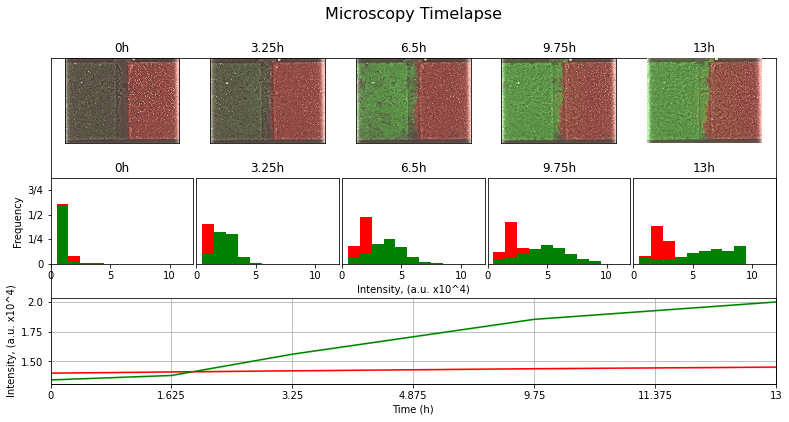

In [245]:
time_series_points = [570, 575, 580, 590, 600]
# time_series_points = [450, 550, 650, 750, 840]
time_points = ['0h', '3.25h', '6.5h', '9.75h', '13h']
input_frames = purge_blank_frames(input_frames)
active_list = []
for time_point in time_series_points:
    _, red, green = input_frames[time_point]

for time_point in time_series_points:
    active_list.append(input_frames[time_point])
generate_frame_and_hist_subplot(active_list, time_series_points, 'Microscopy Timelapse', time_points)


<AxesSubplot:xlabel='timepoint', ylabel='signal'>

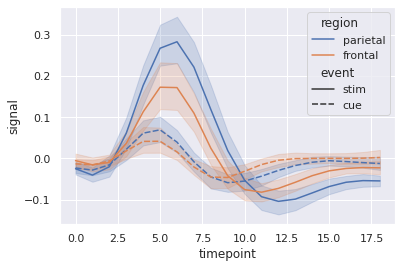

In [1]:
import seaborn as sns
sns.set_theme(style="darkgrid")

# Load an example dataset with long-form data
fmri = sns.load_dataset("fmri")

# Plot the responses for different events and regions
sns.lineplot(
    x="timepoint",
    y="signal",
    hue="region",
    style="event",
    data=fmri,
)



